# Image generation for Sheep Detection

In this notebook we generate new images based on old images by extracting sheep from a image with sheep and randomly rotate and place them on a new image.

In [73]:
%pip install opencv-python pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

In [75]:
ROOT_FOLDER = ".."
DATASET_FOLDER = f"{ROOT_FOLDER}/dataset"
ENHANCED_IMAGE_FOLDER = f"{DATASET_FOLDER}/images/enhanced"
AUGMENTED_IMAGE_FOLDER = f"{DATASET_FOLDER}/images/augmented"

ANNOTATIONS_FILE = f"{DATASET_FOLDER}/annotations.xlsx"

In [76]:
def load_image(path: str) -> np.ndarray:
    """Load an image (in color) from a file path."""
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

def load_annotations(file_path: str) -> pd.DataFrame:
    """Load bounding box annotations from an Excel file into a DataFrame."""
    df = pd.read_excel(file_path)
    # Expect columns: image_name, bbox_x, bbox_y, bbox_width, bbox_height
    required_cols = {"image_name", "bbox_x", "bbox_y", "bbox_width", "bbox_height"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Annotation file missing required columns: {required_cols}")
    return df

def get_bounding_boxes(image_name: str, df: pd.DataFrame) -> List[Tuple[int, int, int, int]]:
    """Return all bounding boxes (x,y,w,h) for a given image name from the annotations DataFrame."""
    rows = df[df['image_name'] == image_name]
    boxes = [(int(r['bbox_x']), int(r['bbox_y']), int(r['bbox_width']), int(r['bbox_height'])) 
            for _, r in rows.iterrows()]
    return boxes

def cut_out_object(image: np.ndarray, box: Tuple[int, int, int, int]) -> np.ndarray:
    """Crop the region defined by the bounding box from the image."""
    x, y, w, h = box
    obj = image[y:y+h, x:x+w].copy()
    # Optionally, to better isolate the sheep, one could set non-sheep pixels to black using a mask.
    # (This would require knowing which pixels are sheep vs background; not done here due to no segmentation mask.)
    return obj

def rotate_image(image: np.ndarray, angle: float) -> np.ndarray:
    """Rotate an image (with background) by a given angle (in degrees) around its center, keeping same size."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, scale=1.0)
    # To prevent clipping, we use the same image size output. (Sheep may have corners cut if rotated a lot.)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=(0,0,0))
    return rotated

def rotate_bounding_box(box: Tuple[int,int,int,int], angle: float, img_shape: Tuple[int,int]) -> Tuple[int,int,int,int]:
    """Rotate a bounding box around image center by a given angle. Returns enclosing axis-aligned bbox of rotated area."""
    # (Note: This is not used further in placement but could be used to adjust annotations if needed.)
    x, y, w, h = box
    img_h, img_w = img_shape
    # Coordinates of box corners relative to image
    corners = np.array([
        [x, y], [x+w, y], [x, y+h], [x+w, y+h]
    ], dtype=np.float32)
    # Translate corners to image center, rotate, then translate back
    center = (img_w/2, img_h/2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    ones = np.ones(shape=(len(corners), 1))
    corners_homog = np.hstack([corners, ones])
    rotated_corners = (M @ corners_homog.T).T  # apply rotation
    # Get enclosing bbox
    x_min, y_min = rotated_corners[:,0].min(), rotated_corners[:,1].min()
    x_max, y_max = rotated_corners[:,0].max(), rotated_corners[:,1].max()
    return (int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min))

def place_object(background: np.ndarray, obj: np.ndarray, x: int, y: int) -> None:
    """Paste the object image onto the background at position (x, y). 
    Non-zero (non-black) pixels of the object will overwrite background."""
    h, w = obj.shape[:2]
    # If the object would go out of bounds, skip placement
    if y < 0 or x < 0 or y + h > background.shape[0] or x + w > background.shape[1]:
        return
    # Create a mask of where the object has non-black pixels (assuming black = background in obj)
    mask = None
    if obj.ndim == 3 and obj.shape[2] == 4:
        # If object has an alpha channel, use it as mask
        mask = obj[:, :, 3] > 0
    else:
        # Otherwise, treat any pixel that is not pure black as part of the object
        mask = (obj[..., :3] > 0).any(axis=2)
    # Overlay the object on the background using the mask
    for c in range(3):  # for each color channel
        background[y:y+h, x:x+w, c][mask] = obj[..., c][mask]

In [77]:
annotations_df = load_annotations(ANNOTATIONS_FILE)

sheep_image_name = "DJI_20240125160538_0008_T.JPG" 
background_image_name = "DJI_20240125160808_0083_T.JPG" 
sheep_image = load_image(os.path.join(ENHANCED_IMAGE_FOLDER, sheep_image_name))
background_image = load_image(os.path.join(ENHANCED_IMAGE_FOLDER, background_image_name))

sheep_boxes = get_bounding_boxes(sheep_image_name, annotations_df)
print(f"Found {len(sheep_boxes)} sheep in source image {sheep_image_name}.")

Found 5 sheep in source image DJI_20240125160538_0008_T.JPG.


In [78]:
def generate_augmented_image(sheep_img: np.ndarray, bg_img: np.ndarray, boxes: List[Tuple[int,int,int,int]], count: int) -> Tuple[np.ndarray, List[Tuple[int,int,int,int]]]:
    """Compose a new image by pasting `count` randomly selected sheep from sheep_img onto a copy of bg_img.
    Returns the new image and a list of bounding boxes for placed sheep (in the new image coordinates)."""
    result = bg_img.copy()
    new_annots: List[Tuple[int,int,int,int]] = []
    placed = 0
    attempts = 0
    # Continue until we place the desired count of sheep or we give up after too many attempts
    while placed < count and attempts < count * 2:
        attempts += 1
        box = random.choice(boxes)                # pick a random sheep from source
        angle = random.uniform(0, 360)            # random rotation angle
        sheep_cutout = cut_out_object(sheep_img, box)
        rotated_cutout = rotate_image(sheep_cutout, angle)
        h, w = rotated_cutout.shape[:2]
        # Random position on background such that the sheep fits entirely
        max_x = bg_img.shape[1] - w
        max_y = bg_img.shape[0] - h
        if max_x < 0 or max_y < 0:
            # Skip this sheep if it's larger than background
            continue
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)
        # Place the sheep; if out of bounds, it'll skip (place_object checks bounds)
        before = len(new_annots)
        place_object(result, rotated_cutout, x, y)
        # If placed (we assume place_object would do nothing if out of bounds), we add annotation
        if len(new_annots) == before:
            # We always add annotation assuming place_object succeeded (it will succeed given our bounds check)
            new_annots.append((x, y, w, h))
            placed += 1
    return result, new_annots

def generate_batch(sheep_img: np.ndarray, bg_img: np.ndarray, boxes: List[Tuple[int,int,int,int]], total_images: int, min_sheep: int = 1, max_sheep: int = 5) -> List[Tuple[np.ndarray, List[Tuple[int,int,int,int]]]]:
    """Generate a batch of `total_images` composite images. Each new image will have a random number of sheep between min_sheep and max_sheep."""
    batch = []
    for _ in range(total_images):
        count = random.randint(min_sheep, max_sheep)
        composite, annots = generate_augmented_image(sheep_img, bg_img, boxes, count)
        batch.append((composite, annots))
    return batch

def display_images_side_by_side(images_with_annots: List[Tuple[np.ndarray, List[Tuple[int,int,int,int]]]], cols: int = 5):
    """Display a list of images (with their annotations) as thumbnails side by side for quick preview."""
    total = len(images_with_annots)
    rows = (total + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    for ax in axes:
        ax.axis('off')
    for ax, (img, annots) in zip(axes, images_with_annots):
        # Draw bounding boxes on a copy for visualization
        vis_img = img.copy()
        for (x, y, w, h) in annots:
            cv2.rectangle(vis_img, (x, y), (x+w, y+h), color=(255, 0, 0), thickness=2)  # blue rectangles for new sheep
        ax.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    plt.show()

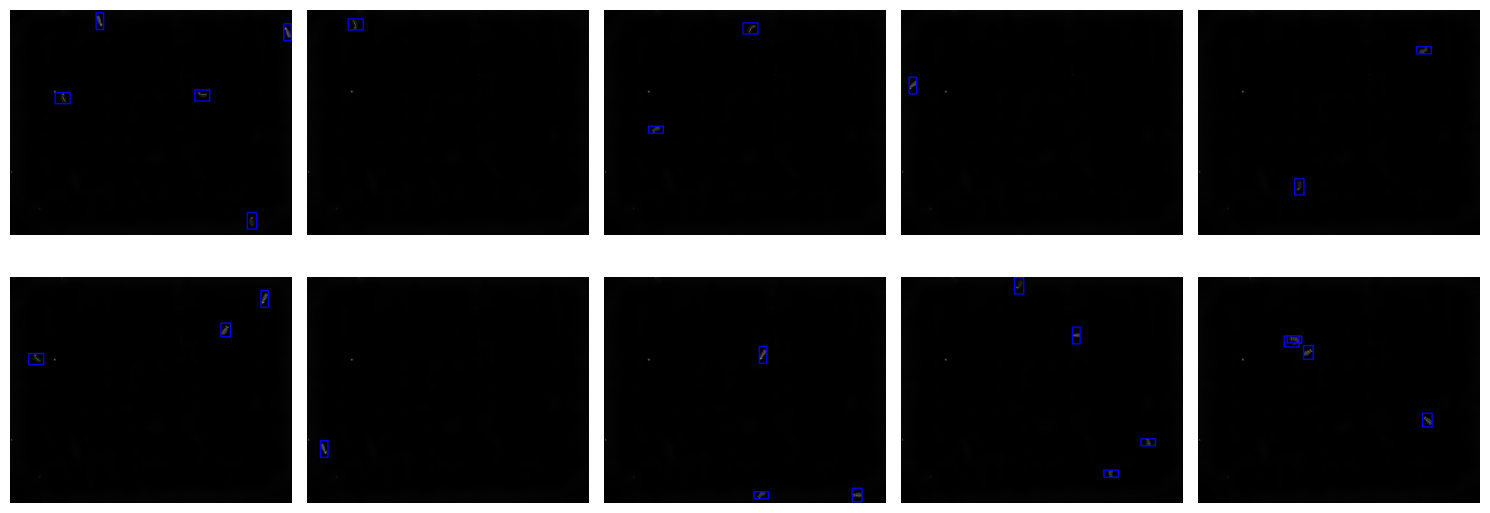

In [79]:
generated = generate_batch(sheep_image, background_image, sheep_boxes, total_images=200, min_sheep=1, max_sheep=5)
display_images_side_by_side(generated[:10], cols=5)

In [80]:
os.makedirs(AUGMENTED_IMAGE_FOLDER, exist_ok=True)
annotations_file = os.path.join(AUGMENTED_IMAGE_FOLDER, "annotations.xlsx")

existing_images = [f for f in os.listdir(AUGMENTED_IMAGE_FOLDER) if f.endswith(".jpg")]
start_idx = len(existing_images)  # how many already present
records = []
for i, (img, boxes) in enumerate(generated, start=start_idx + 1):
    image_name = f"generated_image_{i}.jpg"
    cv2.imwrite(os.path.join(AUGMENTED_IMAGE_FOLDER, image_name), img)
    # record each bounding box in the new image
    for (x, y, w, h) in boxes:
        records.append({
            'image_name': image_name,
            'bbox_x': x,
            'bbox_y': y,
            'bbox_width': w,
            'bbox_height': h
        })
# Append to existing annotations if file exists, otherwise create new
df_new = pd.DataFrame(records)
if os.path.exists(annotations_file):
    df_old = pd.read_excel(annotations_file)
    df_new = pd.concat([df_old, df_new], ignore_index=True)
df_new.to_excel(annotations_file, index=False)
print(f"✅ Saved {len(generated)} augmented images and updated annotations at '{annotations_file}'")

✅ Saved 200 augmented images and updated annotations at '../dataset/images/augmented\annotations.xlsx'
